# Implementation of the computational workflow of "Topological data analysis for revealing structural origin of density anomalies of silica glass"
This jupyter notebook cotains the workflow of the topological data analsysis for the amorphous silica structures obtained from MD simulations

## STEP0 Preparation step

- Import python modules
- Set directory names
- Define various functions used in the TDA

In [1]:
#import python modules
import os
import pickle
import regex as re
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# import matplotlib
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns

# import numpy 
import numpy as np

# import scipy
import scipy
from scipy.spatial.distance import *
from scipy.stats import *

# import scikit-learn
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.manifold import MDS
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# import gtda (Python package to compute PDs and measure distance between them)
from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_diagram, plot_heatmap, plot_betti_curves
from gtda.diagrams import PairwiseDistance, Scaler, Filtering
from gtda.diagrams import BettiCurve, ForgetDimension, PersistenceImage
from gtda.homology._utils import _postprocess_diagrams

# import skfuzzy (to implement fuzzy spectral clustering)
import skfuzzy as fuzz

# import ASE
import ase

#### Utility functions:
- computation of distance between PDs
- fuzzy spectral clustering
- laplacian of a matrix (one of the ingredients of fuzzy spectral clustering)

In [2]:
def compute_distances(diag_dic,metric_params, metric='betti',order=None):
    ordered_keys = sorted([float(x) for x in diag_dic.keys()])
    diagrams = [diag_dic[k] for k in ordered_keys]
    get_distance = PairwiseDistance(metric=metric, metric_params=metric_params, n_jobs=-1, order=order)
    distance = get_distance.fit_transform(diagrams)
    return ordered_keys, diagrams, distance

In [3]:
def compute_pers_diag_and_distances(spins, metric_params, homology_dim, metric='betti', 
                                    point_metric='euclidean', order=None):
    
    ordered_keys = sorted([float(x) for x in spins.keys()])
    VR = VietorisRipsPersistence(metric=point_metric, homology_dimensions=homology_dim, n_jobs=-1, collapse_edges=True)
    diagrams = VR.fit_transform([spins[k] for k in ordered_keys])
    get_distance = PairwiseDistance(metric=metric, metric_params=metric_params, n_jobs=-1, order=order)
    distance = get_distance.fit_transform(diagrams)
    
    return ordered_keys, diagrams, distance

In [4]:
def fuzzy_spectral_clustering(distance, n_clusters, eps1=10, eps2=500, par=2): 
    d = ((distance/eps1).round(decimals=0)*eps1).astype(int)
    affinity_matrix = np.exp(- d ** 2 / (2. * eps2** 2))
    Y = embed(affinity_matrix, n_clusters)
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        Y.T, n_clusters, par, error=0.0005, maxiter=1000, init=None, seed=42)
    return u, fpc

In [5]:
def laplacian(A):
    """Computes the symetric normalized laplacian.
    L = D^{-1/2} A D{-1/2}
    """
    D = np.zeros(A.shape)
    w = np.sum(A, axis=0)
    D.flat[::len(w) + 1] = w ** (-0.5)  # set the diag of D to w
    return D.dot(A).dot(D)

def embed(affinity, n_clusters):
    L = laplacian(affinity)
    eig_val, eig_vect = scipy.sparse.linalg.eigs(L, n_clusters)
    X = eig_vect.real
    rows_norm = np.linalg.norm(X, axis=1, ord=2)
    Y = (X.T / rows_norm).T
    return Y

#### Retrieve data

In [6]:
md_dir = os.path.join(os.getcwd(), f'MDs')
pd_dir = os.path.join(os.getcwd(), f'PDs')
tda_dir = os.path.join(os.getcwd(), f'TDAs')

In [7]:
# reading density
with open(os.path.join(md_dir, f"quench_temp_list.pickle"), mode='rb') as f:
    quench_temp_list=pickle.load(f)
with open(os.path.join(md_dir, f"quench_density_list.pickle"), mode='rb') as f:
    quench_density_list=pickle.load(f)
density_pd=pd.DataFrame(np.array([quench_temp_list, quench_density_list]).T, columns=["Temp","Density"])

In [8]:
# make directories where TDA results will be saved
os.makedirs(tda_dir, exist_ok=True)

In [9]:
# temperatures
pd_plot_t=[300,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000]

In [10]:
# prefix
prefix='Si' #Si, O, or SiO

## STEP1 Computation of Persistence Diagrams (PD)
Computation of Persistence Diagrams (PD) on the last configuration of each temperature T of the MD simulation.
This step is done with another python script, `PD_compute.py`, in the same directory.
The resultant PDs are saved in the PD objects

In [11]:
with open(os.path.join(pd_dir, f'diagrams_{prefix}gtda.pickle'), 'rb') as infile: 
    PD = pickle.load(infile)   

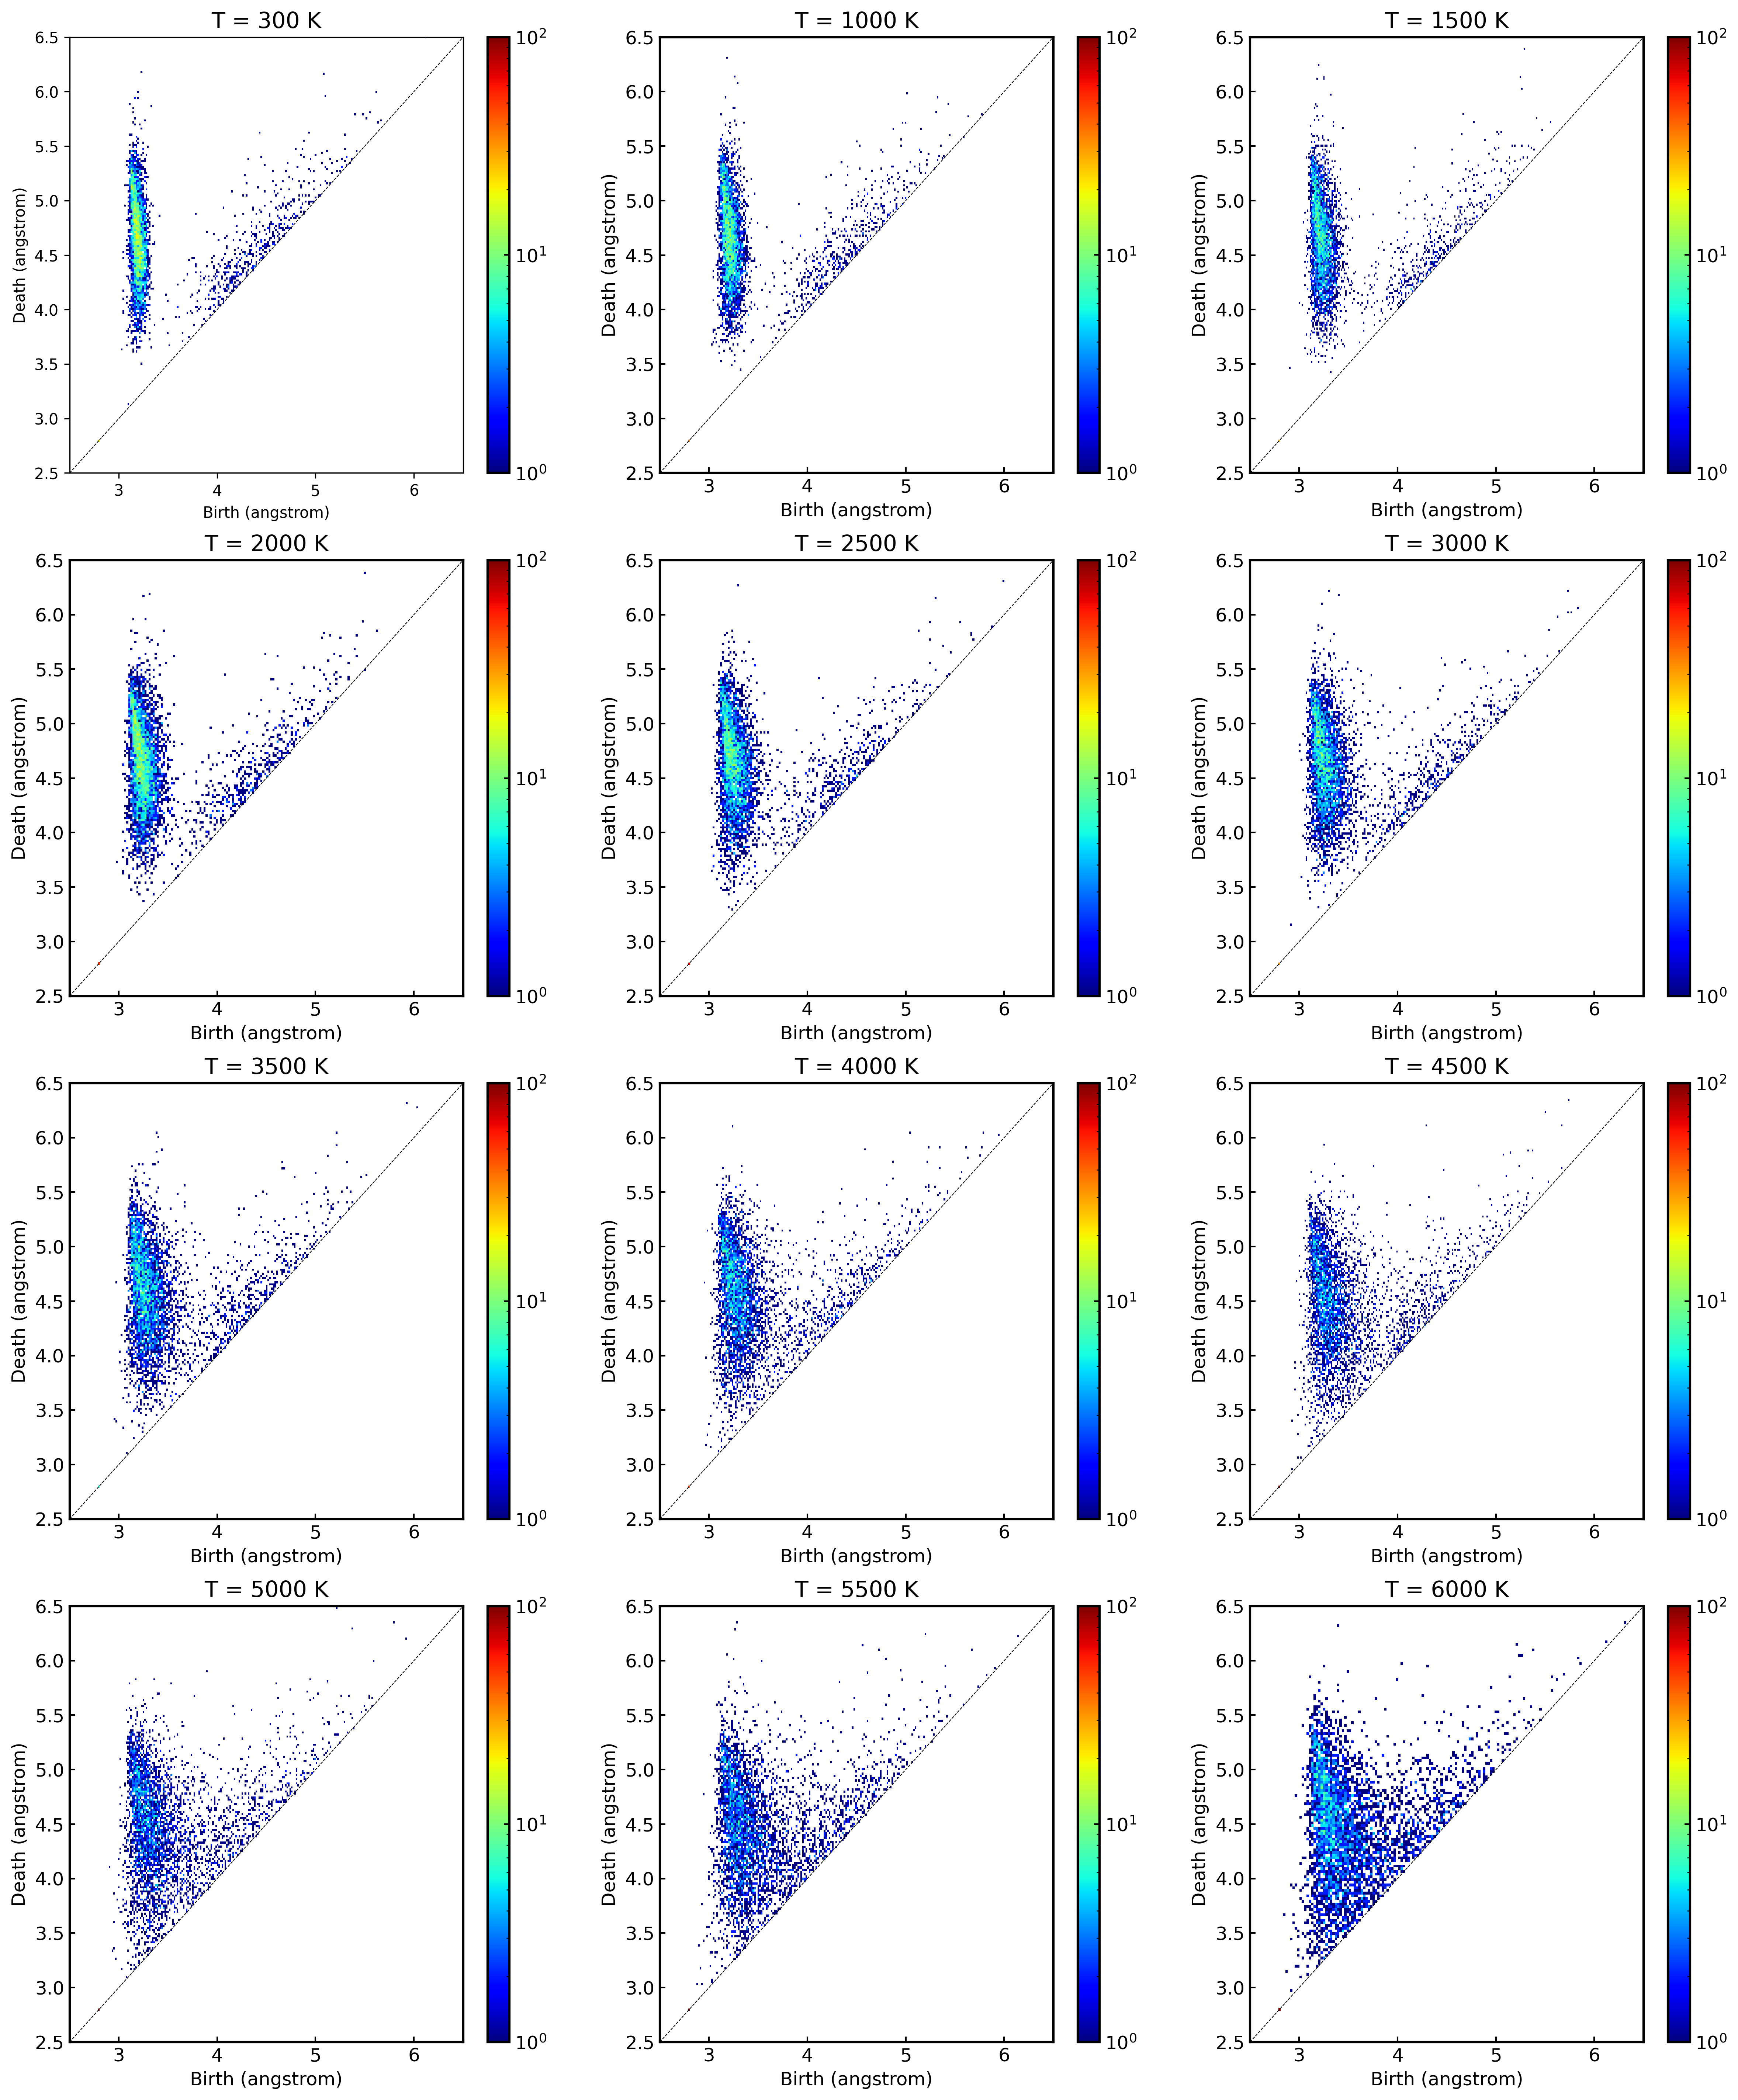

In [12]:
num_t = len(pd_plot_t)
num_col = 3
num_row = int(num_t/num_col)
fig = plt.figure(figsize=(6.5*num_col, 6.0*num_row), facecolor='white', dpi=300)

max_dict={'Si':6.5, 'O':6.0, 'SiO':6.0}
min_dict={'Si':2.5, 'O':2.0, 'SiO':1.0}

plot_t_list=[t for t in PD.keys() if np.round(t,-1) in pd_plot_t]
for i,t in enumerate(plot_t_list):
    data = PD[t]
    h0 = data[data[:,2]==0]
    h1 = data[data[:,2]==1]
    h2 = data[data[:,2]==2]
    
    ax = fig.add_subplot(num_row,num_col,i+1)
    ax.set_ylabel(f"Death (angstrom)")
    ax.set_xlabel(f"Birth (angstrom)")

    plt.rcParams['font.family'] ='sans-serif'
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['xtick.major.width'] = 1.0
    plt.rcParams['ytick.major.width'] = 1.0
    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.linewidth'] = 1.5
    
    min_=min_dict[prefix]; max_=max_dict[prefix]
    H=ax.hist2d(h1[:, 0], h1[:,1], bins=(200, 200), norm=matplotlib.colors.LogNorm(vmin=1e0-0.001, vmax=1e2), cmap=cm.jet)
    ax.set_xlim(min_,max_)
    ax.set_ylim(min_,max_)
    x=np.linspace(min_,max_,1000)
    ax.plot(x,x,linestyle="--",linewidth=0.5,color="k")
    plt.title(f'T = {np.round(t,-1):.0f} K')
    fig.colorbar(H[3],ax=ax)

plt.savefig(os.path.join(pd_dir, f'PD{prefix}.png'))
plt.show()

## STEP2 Computation of pairwise distances
Computation of pairwise distances between PDs, giving rise to a square matrix M such that

In [13]:
PD_filt = {k:v for k, v in PD.items() if k<6500 and k>0}

In [14]:
ordered_keys = sorted(PD_filt.keys())

In [15]:
get_distance = PairwiseDistance(n_jobs=-1, metric='betti', metric_params={'p': 2},order=None) # for a square matrix M

## STEP3 & STEP4: Convert the distance matrix into a similarity matrix, on which we perform fuzzy spectral clustering 
The converstion from ditance to similarity matrix withing the `fuzzy_spectral_clustering` funnction. When performing fuzzy spectral clustering on the similarity matrix $S$ we choose a number of clusters equal to the number of expected transitions +1

In [16]:
distance = get_distance.fit_transform([PD_filt[k] for k in ordered_keys]) # a similarity matrix S

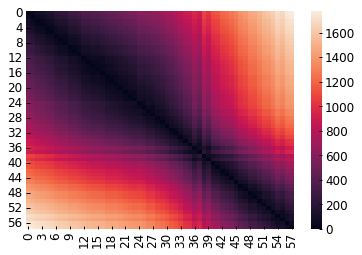

In [17]:
# plot heatmaps (H^1)
sns.heatmap(distance[:,:,1])
plt.show()

In [18]:
par = 1.2 # parameter lambda
u_0, _ = fuzzy_spectral_clustering(distance[:, :, 0], 3, par=par)
u_1, _ = fuzzy_spectral_clustering(distance[:, :, 1], 3, par=par)
u_2, _ = fuzzy_spectral_clustering(distance[:, :, 2], 3, par=par)

## STEP5 Determine the transition points
With the memebership functions obtained from 4., determine the transition points as the intersection of the membership curves.

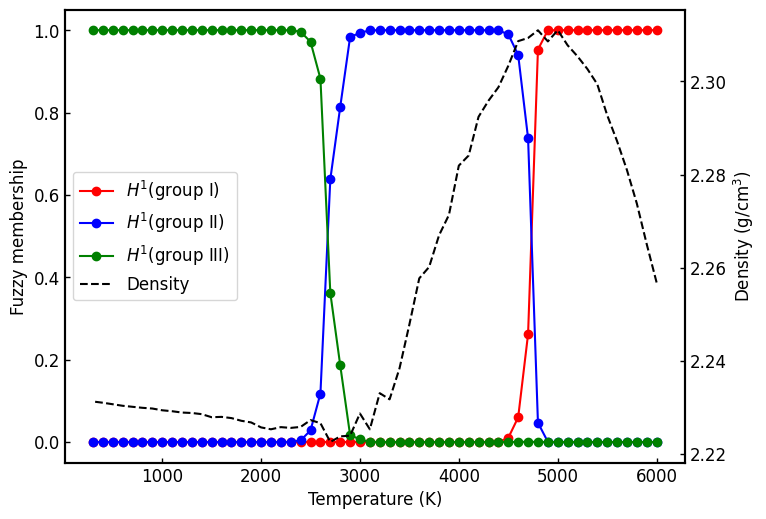

In [19]:
fig = plt.figure(figsize=(8, 6), facecolor='white', dpi=100)
ax1 = fig.add_subplot(1,1,1)
ax1.set_ylabel(f"Fuzzy membership")
ax1.set_xlabel(f"Temperature (K)")
ax2 = ax1.twinx()
ax2.set_ylabel(r"Density (g/cm$^3$)")

plt.rcParams['font.family'] ='sans-serif'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = 1.0
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.5

ax1.plot(ordered_keys, u_1[0], color="r", label='$H^1$(group I)', marker="o")
ax1.plot(ordered_keys, u_1[1], color="b", label='$H^1$(group II)', marker="o")
ax1.plot(ordered_keys, u_1[2], color="g", label='$H^1$(group III)', marker="o")
ax2.plot(density_pd["Temp"], density_pd["Density"], color="k", linestyle='--', label="Density")

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper right')
ax1.legend(h1+h2, l1+l2)
plt.savefig(os.path.join(tda_dir, f'{prefix}-tda.png'))
plt.show()